# Lab 01 - Techniques for Handling Large Datasets in Classification

In this scenario we will explore several techniques for handling large datasets in classification tasks. We will compare the performance of different approaches, including:

- using the full dataset
- using sampling techniques
- using summarization techniques

## 1. Dataset download

During this lab, we will use the [NYC Yellow Taxi Trip Data](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data) from Kaggle.
In fact, this is a subset of the much larger and continuously updated dataset available from the [NYC Taxi & Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The original dataset is evolving over time, with respect to its schema, therefore to avoid issues, we will use a preprocessed version from a Kaggle user.

Action:

- Get familiar with the dataset page, read the description, check available columns, as well as their types and meaning.
- Download all available CSV files - use any means you prefer (Kaggle API, kagglehub package, direct download using browser, etc.).

In [ ]:
# write your code here


## 2. 

In [2]:
import pandas as pd
import numpy as np
import pathlib
import pyarrow.parquet as pq
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder
import datetime
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt

DATA_DIR = pathlib.Path(".") / ".." / ".." / "data"


In [3]:
df = pd.read_parquet(DATA_DIR / "taxi_cash.parquet")
total_gb = df.memory_usage(deep = True).sum() / 10**9
print(f"Memory usage: {total_gb:.2f} GB")

Memory usage: 6.48 GB


In [ ]:
df.drop(columns=["RateCodeID", "RatecodeID"], inplace=True)
df.dropna(inplace=True)
df = df.sort_values(by="tpep_pickup_datetime").reset_index(drop=True)

In [18]:
sample_index = df.sample(frac=0.05).index.sort_values()

In [26]:
LARGE_TIP_THRESHOLD = 0.17

data = df.loc[sample_index].copy()
tip_amount = data["tip_amount"]
data.drop(columns=["tip_amount"], inplace=True)
target = tip_amount >= LARGE_TIP_THRESHOLD * (data["total_amount"] - tip_amount)
time = data["tpep_pickup_datetime"].dt.date


In [75]:
float_cols = [
    col
    for col in data.select_dtypes(include=np.float64).columns
    if data[col].nunique() > 5
]
float_cols_1 = [
    "trip_distance",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "fare_amount",
    "extra",
    "tolls_amount",
]
float_cols_2 = [
    "total_amount",
]

datetime_cols = [col for col in data.select_dtypes(include=np.datetime64).columns]
object_cols = [col for col in data.select_dtypes(include=object).columns]

transformer_nb = make_column_transformer(
    # (
    #     KBinsDiscretizer(
    #         n_bins=100, encode="ordinal", quantile_method="averaged_inverted_cdf"
    #     ),
    #     float_cols,
    # ),
    (
        KBinsDiscretizer(
            n_bins=5, encode="ordinal", quantile_method="averaged_inverted_cdf"
        ),
        float_cols_1,
    ),
    (
        KBinsDiscretizer(
            n_bins=100,
            encode="ordinal",
            strategy="quantile",
            # n_bins=100, encode="ordinal", quantile_method="averaged_inverted_cdf"
        ),
        float_cols_2,
    ),
    (
        FunctionTransformer(lambda x: x.apply(lambda col: col.dt.isocalendar().week)),
        datetime_cols,
    ),
    (
        OrdinalEncoder(),
        object_cols,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
encoder_nb = OrdinalEncoder()

transformer_nb_2 = make_column_transformer(
    (
        KBinsDiscretizer(
            n_bins=100,
            encode="ordinal",
            strategy="quantile",
            # n_bins=100, encode="ordinal", quantile_method="averaged_inverted_cdf"
        ),
        float_cols_2,
    ),
    (
        FunctionTransformer(lambda x: x.apply(lambda col: col.dt.isocalendar().week)),
        datetime_cols,
    ),
    (
        OrdinalEncoder(),
        object_cols,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
encoder_nb_2 = OrdinalEncoder()



transformer_tree = make_column_transformer(
    (
        FunctionTransformer(lambda x: x.apply(lambda col: col.dt.isocalendar().week)),
        datetime_cols,
    ),
    (
        OrdinalEncoder(),
        object_cols,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)


data_nb = encoder_nb.fit_transform(transformer_nb.fit_transform(data))

data_nb_2 = encoder_nb_2.fit_transform(
    transformer_nb_2.fit_transform(
        data.drop(
            columns=[
                "trip_distance",
                "pickup_longitude",
                "pickup_latitude",
                "dropoff_longitude",
                "dropoff_latitude",
                "fare_amount",
                "extra",
                "tolls_amount",
            ]
        )
    )
)

data_tree = transformer_tree.fit_transform(data)


/home/sebov/synced/backup/workspace/dzd/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/sebov/synced/backup/workspace/dzd/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/sebov/synced/backup/workspace/dzd/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/sebov/synced/backup

In [74]:
data.drop(
            columns=[
                "trip_distance",
                "pickup_longitude",
                "pickup_latitude",
                "dropoff_longitude",
                "dropoff_latitude",
                "fare_amount",
                "extra",
                "tolls_amount",
            ]
        )

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,store_and_fwd_flag,payment_type,mta_tax,improvement_surcharge,total_amount
23,1,2015-01-01 00:00:50,2015-01-01 00:14:50,1,N,1,0.5,0.0,24.40
59,1,2015-01-01 00:01:36,2015-01-01 00:04:09,1,N,1,0.5,0.0,5.75
61,2,2015-01-01 00:01:37,2015-01-01 00:06:00,5,N,1,0.5,0.3,6.80
68,1,2015-01-01 00:01:44,2015-01-01 00:20:46,2,N,1,0.0,0.0,78.35
88,1,2015-01-01 00:02:05,2015-01-01 00:11:00,1,N,1,0.5,0.0,9.35
...,...,...,...,...,...,...,...,...,...
30870523,1,2016-03-31 23:59:34,2016-04-01 00:04:23,1,N,1,0.5,0.3,7.30
30870576,2,2016-03-31 23:59:49,2016-04-01 00:27:36,4,N,1,0.5,0.3,38.76
30870595,2,2016-03-31 23:59:55,2016-04-01 00:07:17,1,N,1,0.5,0.3,11.00
30870599,1,2016-03-31 23:59:57,2016-04-01 00:12:09,1,N,1,0.5,0.3,14.15


In [76]:
def assess(cl, X, y):
    mask = (time < datetime.date(2016, 3, 1)).to_numpy()
    X_train = X[mask]
    y_train = y[mask]

    mask = time > datetime.date(2016, 3, 15)
    X_test = X[mask]
    y_test = y[mask]



    cl.fit(X_train, y_train)
    print(balanced_accuracy_score(y_test, cl.predict(X_test)))
    return cl


cl = assess(DecisionTreeClassifier(min_samples_leaf=5000), data_tree, target)
cl2 = assess(CategoricalNB(), data_nb, target)
cl3 = assess(CategoricalNB(), data_nb_2, target)


0.8645722158100364
0.7158843069423331
0.7067073481970423


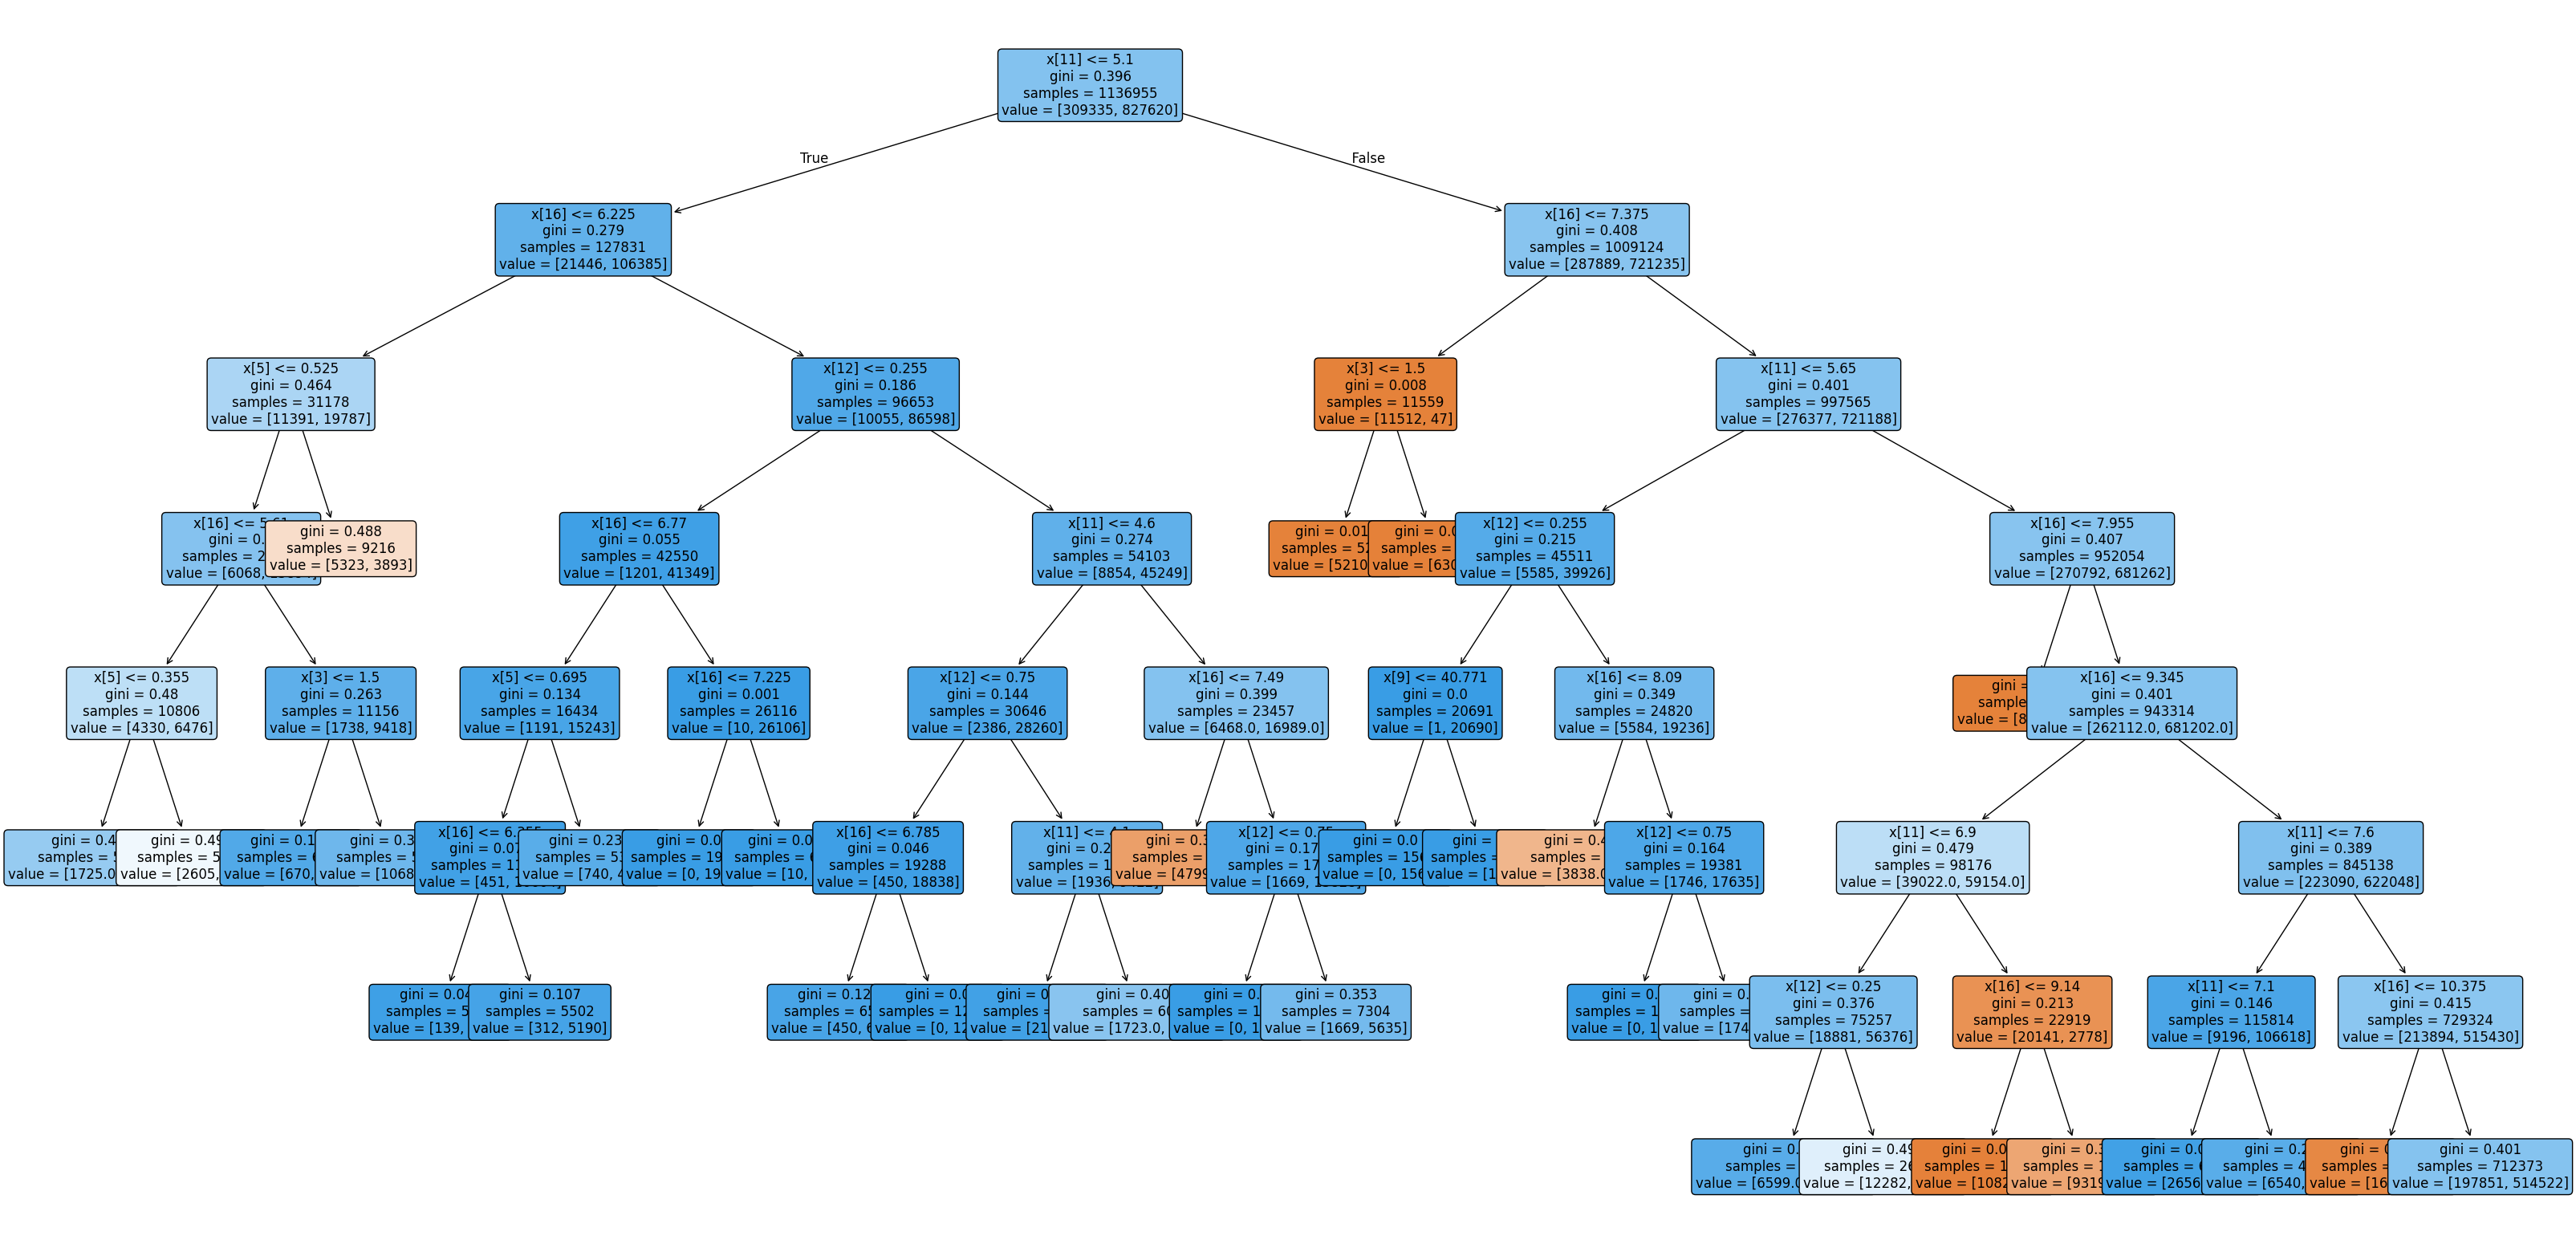

In [64]:
plt.figure(figsize=(40, 20))
plot_tree(
    cl,
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.show()